# First Exploration and Tests

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.
(Marc Lenz, 2021)


It serves the purpose of exploring samples of the relevant Datasets and testing some basic algorithms. 

**So far the basic steps are:**

- Loading and Preprocessing Data of JRQ-Arquis (Sample, English-French)
- Traning some baseline document embeddings using gensim
- Implementing a basic Concept approximation function, which maps document representations from one language to another


##  1. Loading and preprocessing of the Dataset

Load file, transform the XML into a usable format in this context

In [1]:
from Utils import extract_docs_from_jrq_xml
import xml.etree.ElementTree as ET


# parse an xml file by name
tree = ET.parse('Data/alignedCorpus-en-fr.xml')
documents = extract_docs_from_jrq_xml(tree, align="documents", doc_limit=2000)


Since we want to train models and do some parameter selection later on, it makes sense to split the dataset into a training and test dataset. From now on, we will apply all methods only to the training dataset. Later on, we will use the test dataset to evaluate the performance of the learned functions. 

In [2]:
from sklearn.model_selection import train_test_split
documents, test_documents = train_test_split(documents, test_size=0.5, random_state=42)

Lets take a look: 

In [3]:
#show whats in there
print(documents[1].keys())
print(documents[1]["english"][:100])
print(documents[1]["french"][:100])

dict_keys(['english', 'french'])
Decision of the EEA Joint CommitteeNo 116/2005of 30 September 2005amending Annex II (Technical regul
Décision du Comité mixte de l'EEENo 116/2005du 30 septembre 2005modifiant l'annexe II (Réglementatio


-> Preprocessing: Tokenization, lemmatization

In [4]:
from Preprocessor import Preprocessor
#Recources needed, uncomment if needed/error   
#nltk.download('punkt')
#nltk.download('wordnet')

# Make sure no empty documents are passed, filter those
filtered_docs = []
for doc in documents:
    if len(doc["english"]) > 0 and len(doc["french"]) > 0:
        filtered_docs.append(doc)
        
#preprocessing, text -> tokenized and stemmed/lemmatized words       
preprocessor_english = Preprocessor(language="en")
preprocessor_french = Preprocessor(language="fr")

french_docs_preprocessed = [preprocessor_french.preprocess(doc["french"]) for doc in filtered_docs]
english_docs_preprocessed = [preprocessor_english.preprocess(doc["english"]) for doc in filtered_docs]


Take a look at a snippet of the preprocessed documents: 

In [5]:
print(french_docs_preprocessed[1][:10])
print(english_docs_preprocessed[1][:10])

['d', 'cision', 'du', 'com', 'mixt', 'de', 'l', 'eeeno', 'du', 'septembr']
['decision', 'of', 'the', 'eea', 'joint', 'committeeno', 'of', 'september', 'amending', 'annex']


## 2.Training of the Monlingual Representations

The first step is to prepare the data: 

In [6]:
from Utils import create_corpus
     
french_dictionary, french_corpus = create_corpus(french_docs_preprocessed)
english_dictionary, english_corpus = create_corpus(english_docs_preprocessed)

print("Vocabulary:")
print("Unique English words: "+ str(len(french_dictionary)))
print("Unique French words: "+str(len(english_dictionary)))



Vocabulary:
Unique English words: 3273
Unique French words: 4016

After Removing extreme frequencies:
Unique English words: 3273
Unique French words: 4016


In [7]:
print(french_dictionary)
print("Example BOW Representation:")
print(french_corpus[0][:10])
print("...")

Dictionary(3273 unique tokens: ['accept', 'accompl', 'accord', 'accordentr', 'accordsan']...)
Example BOW Representation:
[(0, 2), (1, 1), (2, 27), (3, 1), (4, 1), (5, 2), (6, 5), (7, 1), (8, 1), (9, 4)]
...


Now Prepare Monolingual Representations: 

In [8]:
from gensim import models

french_tfidf = models.TfidfModel(french_corpus)
french_corpus_tfidf = french_tfidf[french_corpus]

english_tfidf = models.TfidfModel(english_corpus)
english_corpus_tfidf = english_tfidf[english_corpus]


Train the LSI model for additional topic numbers/embedding dimensions

In [9]:
model_dict = dict()
dimensions = [12, 25, 50, 100, 200, 500, 800]

for dimension in dimensions:
    french_lsi_model = models.LsiModel(french_corpus_tfidf, 
                            id2word=french_dictionary, 
                            num_topics=dimension)  

    english_lsi_model = models.LsiModel(english_corpus_tfidf, 
                            id2word=english_dictionary, 
                            num_topics=dimension) 
    
    lsi_models = {"en": english_lsi_model,
                 "fr": french_lsi_model}
    
    model_dict[dimension] = lsi_models

Now save the Vector Representations within the same dictionary

In [10]:
import numpy as np
#Convert the Tuple representations into Numpy vectors
for dimension in dimensions:
    english_lsi_model = model_dict[dimension]["en"]
    english_lsi_vec = english_lsi_model[list(english_corpus_tfidf)]
    english_lsi_vec = list(english_lsi_vec)
    english_lsi_vecs = []
    for tupel_list in english_lsi_vec:
        vec_rep = list(zip(*tupel_list))
        english_lsi_vecs.append(np.array(vec_rep[1]))
    
    french_lsi_model = model_dict[dimension]["fr"]
    french_lsi_vec = french_lsi_model[list(french_corpus_tfidf)]
    french_lsi_vec = list(french_lsi_vec)
    french_lsi_vecs = []
    for tupel_list in french_lsi_vec:
        vec_rep = list(zip(*tupel_list))
        french_lsi_vecs.append(np.array(vec_rep[1]))
        
    model_dict[dimension]["en_vecs"] = english_lsi_vecs
    model_dict[dimension]["fr_vecs"] = french_lsi_vecs

# 3. Linear Concept Approximation
- The goal is to find a (linear) mapping $\phi : C_{X} \rightarrow{C_{Y}}$ 
- Therefore it is more convenient to have vector and matrix represenations using numpy

Now, in order to find the mapping $\phi$, we can set an objective for the function, we will use linear least squares with $min_{\phi\in \mathbb{R}^{m\times m}}||\phi(\hat{C_{x}})-\hat{C_{y}}||^{2}_{2}$.

Here, $\hat{C_{x}}, \hat{C_{y}}$ are matrices obtained by mapping aligned documents into the respective concept-space represenation.

Since those documents are only samples which we observed within the concept-spaces, 


- What is a good sample size to train Linear Concept Approximation? 
- How many samples are needed at least? 
- Where is the point of diminishing returns regarding sample size?

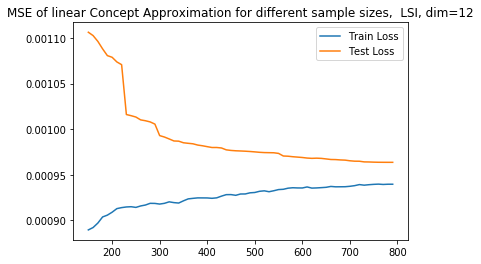

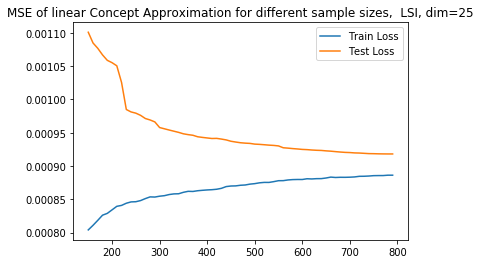

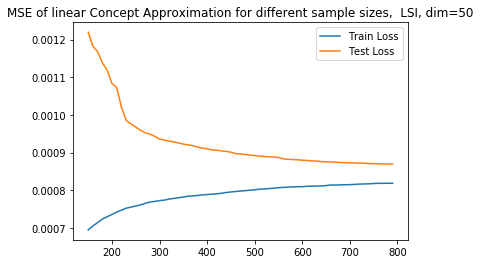

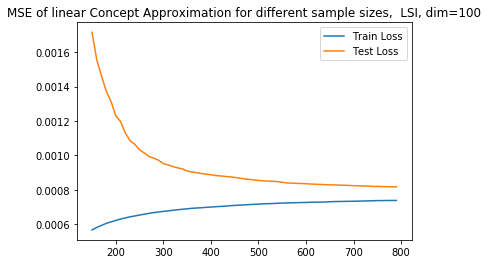

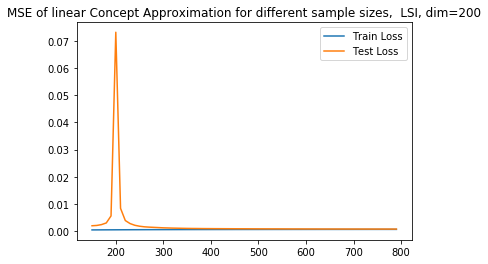

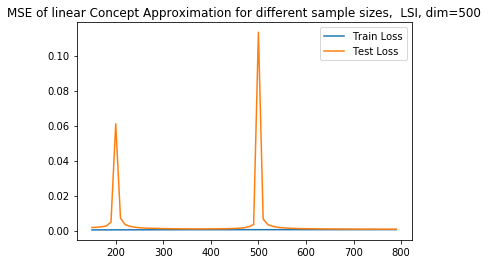

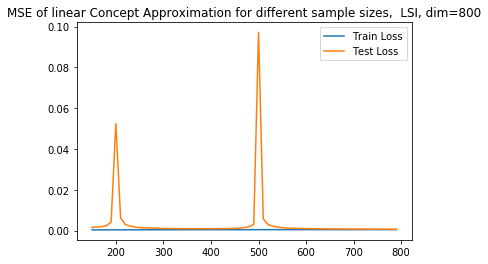

In [11]:
meta_train_scores = []
meta_test_scores = []

from sklearn import linear_model
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error as mse
        
for dimension in dimensions:
    english_lsi_vecs = model_dict[dimension]["en_vecs"]
    english_lsi_vecs = model_dict[dimension]["fr_vecs"]
    
    for k in range(4):
        en_vecs_train, en_vecs_test, fr_vecs_train, fr_vecs_test = train_test_split(english_lsi_vecs, french_lsi_vecs, test_size=0.2)

        sample_sizes = [k*10 for k in range(15,80)]
        train_scores = []
        test_scores = []

        for num in sample_sizes:
            fr_to_en_clf = linear_model.LinearRegression()
            en_to_fr_clf = linear_model.LinearRegression()
            
            en_to_fr_clf.fit(en_vecs_train[:num], fr_vecs_train[:num])
            train_predictions = en_to_fr_clf.predict(en_vecs_train[:num])
            train_score = mse(train_predictions, fr_vecs_train[:num])

            test_predictions = en_to_fr_clf.predict(en_vecs_test)
            test_score = mse(test_predictions, fr_vecs_test)
            train_scores.append(train_score)
            test_scores.append(test_score)

        meta_train_scores.append(np.asarray(train_scores))
        meta_test_scores.append(np.asarray(test_scores))

    plt.plot(sample_sizes, np.mean(meta_train_scores, axis=0), label="Train Loss")  
    plt.plot(sample_sizes, np.mean(meta_test_scores, axis=0), label="Test Loss")
    plt.legend()
    plt.title("MSE of linear Concept Approximation for different sample sizes,  LSI, dim="+str(dimension))
    plt.show()

Going from 500, the MSE for the training and test dataset does not change much anymore. Now Train it with the full training data. 

- Just Train Classifier on whole training data as long as it is not too large

In [21]:

from sklearn.metrics.pairwise import cosine_similarity

for dimension in dimensions:
    
    english_lsi_vecs = model_dict[dimension]["en_vecs"] 
    french_lsi_vecs = model_dict[dimension]["fr_vecs"] 

    fr_to_en_clf = linear_model.LinearRegression()
    en_to_fr_clf = linear_model.LinearRegression()

    en_to_fr_clf.fit(english_lsi_vecs, french_lsi_vecs)
    fr_to_en_clf.fit(french_lsi_vecs, english_lsi_vecs)
    
    model_dict[dimension]["en_to_fr_clf"] = en_to_fr_clf
    model_dict[dimension]["fr_to_en_clf"] = fr_to_en_clf

So now we have obtained $\phi_{en\rightarrow fr}, \phi_{fr\rightarrow en}$ which provide us with mappings between the two different concept spaces of French and English Documents. What we would like to know now is how useful those functions actually are. 

## 4. Evaluation

- How well do the Representations obtained by the linear concept approximation work for the task of multilingual document retrieval? 
- 1. Preprocess the Test-Documents which were seperated before

In [13]:
filtered_test_docs = []
for doc in test_documents:
    if len(doc["english"]) > 0 and len(doc["french"]) > 0:
        filtered_test_docs.append(doc)
        
fr_test_docs_preprocessed = [preprocessor_french.preprocess(doc["french"]) for doc in filtered_test_docs]
en_test_docs_preprocessed = [preprocessor_english.preprocess(doc["english"]) for doc in filtered_test_docs]

print("Number of Documents: " +str(len(fr_test_docs_preprocessed)))

Number of Documents: 967


In [26]:

for dimension in dimensions:
    english_lsi_model = model_dict[dimension]["en"]
    french_lsi_model = model_dict[dimension]["fr"]
    
    french_vecs = []
    for doc in fr_test_docs_preprocessed:
        vec_bow = french_dictionary.doc2bow(doc)
        bow_tfidf = french_tfidf[vec_bow]
        vec_lsi = french_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        french_vecs.append(vec_rep)

    english_vecs = []
    for doc in en_test_docs_preprocessed:
        vec_bow = english_dictionary.doc2bow(doc)
        bow_tfidf = english_tfidf[vec_bow]
        vec_lsi = english_lsi_model[bow_tfidf]  
        vec_rep = np.asarray(list(zip(*vec_lsi))[1])
        #This is here because of weird error, has to be fixed
        if vec_rep.shape[0]!= dimension:
             english_vecs.append(np.zeros(dimension))
        else:
            english_vecs.append(vec_rep)
        
    model_dict[dimension]["en_test_vecs"] = english_vecs
    model_dict[dimension]["fr_test_vecs"] = french_vecs
        
    #Apply mapping into other concept space as well and save
    en_to_fr_clf = model_dict[dimension]["en_to_fr_clf"] 
    fr_to_en_clf = model_dict[dimension]["fr_to_en_clf"] 
    model_dict[dimension]["en_to_fr_test_vecs"] = en_to_fr_clf.predict(english_vecs)
    model_dict[dimension]["fr_to_en_test_vecs"] = fr_to_en_clf.predict(french_vecs)

(967, 12)
(967, 25)
(967, 50)
(967, 100)
(967, 200)
(967, 500)
(967, 800)


Best Mate Retrival Score is archieved for Dim=500. With a score of: 0.8965873836608066


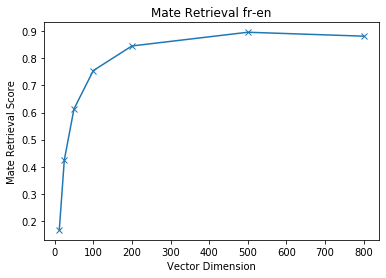

Best Mate Retrival Score is archieved for Dim=500. With a score of: 0.8490175801447777


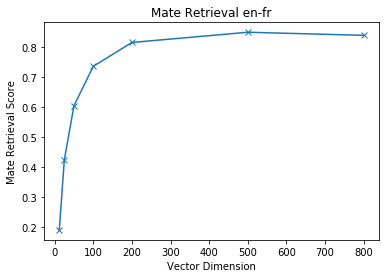

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

def mate_retrieval_plot(l1_vecs, l1_test_vecs, l2tol1_test_vecs, title):
    mate_retrieval_scores = []

    for dim in dimensions:

        en_vectors = model_dict[dim][l1_vecs]
        en_test_vectors = model_dict[dim][l1_test_vecs]
        fr_to_en_test_vectors = model_dict[dim][l2tol1_test_vecs]

        sim_matrix = cosine_similarity(en_test_vectors+en_vectors, fr_to_en_test_vectors)
        mate_scores = np.diagonal(cosine_similarity(en_test_vectors, fr_to_en_test_vectors))

        highest_similarity_score = np.max(sim_matrix, axis=0)
        mate_retrieval_score = np.sum(highest_similarity_score == mate_scores)/len(mate_scores)

        mate_retrieval_scores.append(mate_retrieval_score)

    max_value = np.max(mate_retrieval_scores)
    best_dim_ind = np.where(mate_retrieval_scores == max_value)[0][0]
    best_dim = dimensions[best_dim_ind]


    plt.plot(dimensions, mate_retrieval_scores, "-x")
    plt.xlabel('Vector Dimension')
    plt.ylabel('Mate Retrieval Score')
    plt.title("Mate Retrieval " +title)
    print("Best Mate Retrival Score is archieved for Dim="+str(best_dim)+\
             ". With a score of: "+str(max_value))
    plt.show()

    
mate_retrieval_plot("en_vecs","en_test_vecs","fr_to_en_test_vecs", title= "fr-en")
mate_retrieval_plot("fr_vecs","fr_test_vecs","en_to_fr_test_vecs", title= "en-fr")